In [1]:
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
folders = [x[0] for x in os.walk('images')][1:]

In [3]:
images = []
for folder in folders:
    with open(folder+'//filelist_LBP.txt', 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for img_name, left, top, right, bottom, new_size_y, new_size_x in reader:
            img = Image.open(folder+'//'+img_name).resize((int(new_size_y), int(new_size_x))).crop((int(left), int(top), int(right), int(bottom))).resize((100,100))
            
            # some images are black and white, for PCA to work correctly need to convert those to rgb
            if (len(np.array(img).shape) != 3 or np.array(img).shape[2] != 3):
                rgbimg = Image.new("RGB", img.size)
                rgbimg.paste(img)
                images.append(rgbimg)
            else:
                images.append(img)
            if (len(np.array(images[-1]).shape) != 3 or np.array(images[-1]).shape[2] != 3):
                print ("Image was not processed correctly " + folder + '//' + img_name)

Showing few random faces from the dataset.

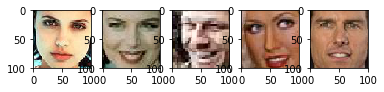

In [4]:
num_faces = 5

for i in range(1, num_faces+1):
    img = random.choice(images)
    plt.subplot(2, num_faces, i)
    plt.imshow(img)

In [5]:
import glob
import os 
from os.path import join as pjoin
import cv2

def imread(imgpath):
    return cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)

def resize(img, imgshape):
    return cv2.resize(img, (imgshape[1], imgshape[0]))

def imshow(img, cmap=None):
    plt.title(img.shape)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')

def get_data_matrix(dataset_path, imgshape, m=None, m_start=0, m_freq=1, color=True, ext='jpg'):
    """
    imgshape -- np.array([h, w]) -- spatial size of the frames
    m -- number of frames,
         if None then all the images in dataset_path will be used
    m_start -- number of the frame from which data matrix starts
    m_freq -- frequency of frames to collect in data matrix
    """
    imgpaths = sorted(glob.glob(pjoin(dataset_path, '*.{}'.format(ext))))
    m = len(imgpaths) 
#     // m_freq if m is None else min(m, len(imgpaths) // m_freq)
    if color:
        imgshape = np.array([*imgshape, 3])
#         print(imgshape)
        X = resize(imread(imgpaths[m_start]), imgshape).reshape((-1,1))
#         print("X= ", X.shape)
        for imgpath in imgpaths:
#         [m_start + m_freq : m_start + m*m_freq : m_freq]:
#             print(imgpath, i)
            img = resize(imread(imgpath), imgshape)
#             print(img.shape)
            img_vec = img.reshape((-1,1))
#             print(img_vec.shape)
#             temp = img_vec.reshape((100,100,3))
#             print(img-temp)
            X = np.hstack((X, img_vec))
#             imshow(img_vec)
    return X


In [6]:
def stack_images(matrices, k=5, imgshape=None, captions=None, leftcaption=None):
    """
        matrices -- (N, *imgshape, k) array,
                    where N is the number of `matrices`,
                          k is the number of images in each `matrix`
    """
    assert imgshape is not None, 'Please specify the spatial size of the frames (imgshape)'
    k = min(matrices[0].shape[-1], k)
    N = len(matrices)
    num_cols, num_rows = N, 1
    if captions is None:
        captions = ['']*N
    matrices_ = []
    if len(imgshape) == 2:
        print('here')
        for m in matrices:
            M = m.reshape((*imgshape,-1)).transpose(2,0,1)[:k]
            print(M.shape)
            matrices_.append(M)
    else:
        for m in matrices:
            M = m.reshape((*imgshape,-1)).transpose(3,0,1,2)[:k]
            print(M.shape)
            matrices_.append(M)
    for k_ in range(k):
        for i in range(N):
            plt.subplot(num_rows, num_cols, i+1)
            imshow(matrices_[i][k_])
            plt.title(captions[i])
            if i == 0:
                plt.title(leftcaption, loc='left')
        plt.show()

### Implementing eigenfaces with SVD

Implement eigenfaces using singular value decomposition (SVD). Remember to represent the images properly and account for the color.

In [7]:
# =============== TODO: Your code here ===============
# Represent the images as a matrix for SVD decompotision.
dataset_path = folders[9]
imgshape = np.array([100, 100]) # spatial size of the frame

X = get_data_matrix(dataset_path, imgshape)
print(X.shape)
# ====================================================

(30000, 120)


In [8]:
# M = (X, X)
# # imshow(images[0])
# stack_images(M, k=10, imgshape=np.array([100, 100, 3]))

In [9]:
from scipy import linalg as LA

def bmSVD(X, k, color=True):
    """
    k -- rank of the low-rank matrix approximation
    """
    U, S, VT = LA.svd(X, full_matrices=False)
    
    Sigma = np.eye(k)*S[:k]
    A = U[:,:k].dot(Sigma).dot(VT[:k,:])
    
    print(Sigma.shape, U[:,:k].shape, VT[:k,:].shape)

    if color:
        # A = np.round(np.minimum(np.maximum(A, 0), 255)).astype(np.uint8)
        # A = np.minimum(np.maximum(A, 0), 255).astype(np.uint8)
        # E = np.maximum(X-A,0)
        # A = A.astype(np.uint8)
        A = np.round(np.minimum(np.maximum(A, 0), 255)).astype(np.uint8)
#     E = X - A
    return A

In [10]:
# =============== TODO: Your code here ===============
# Implement eigenfaces using singular value decomposition (SVD). 
# Remember to represent the images properly and account for the color.

### PARAMS
##########
SVDs = []
num_eigenfaces = 10
for i in range (num_eigenfaces):
    SVD = bmSVD(X, i)
    SVDs.append(SVD)
#     np.append(SVDs, SVD)

(0, 0) (30000, 0) (0, 120)
(1, 1) (30000, 1) (1, 120)
(2, 2) (30000, 2) (2, 120)
(3, 3) (30000, 3) (3, 120)
(4, 4) (30000, 4) (4, 120)
(5, 5) (30000, 5) (5, 120)
(6, 6) (30000, 6) (6, 120)
(7, 7) (30000, 7) (7, 120)
(8, 8) (30000, 8) (8, 120)
(9, 9) (30000, 9) (9, 120)


In [11]:
SVDs[0].shape

(30000, 120)

In [12]:
# imgshape = np.array([100, 100, 3])
# M = SVD['A'].reshape((*imgshape,-1)).transpose(3,0,1,2)[:]
# imshow(M)
# # ====================================================

Visualize 10 eigenfaces associated with the highest eigenvalues.

1 and 2 eigenfaces
(1, 100, 100, 3)
(1, 100, 100, 3)


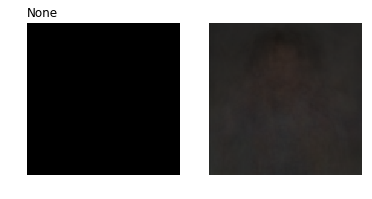

3 and 4 eigenfaces
(1, 100, 100, 3)
(1, 100, 100, 3)


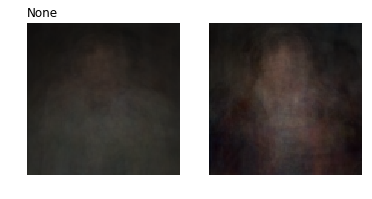

5 and 6 eigenfaces
(1, 100, 100, 3)
(1, 100, 100, 3)


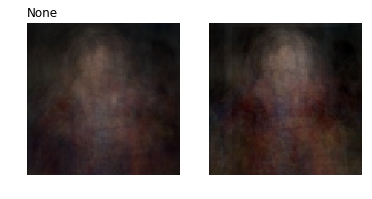

7 and 8 eigenfaces
(1, 100, 100, 3)
(1, 100, 100, 3)


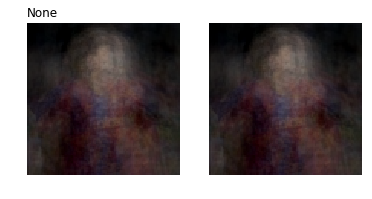

9 and 10 eigenfaces
(1, 100, 100, 3)
(1, 100, 100, 3)


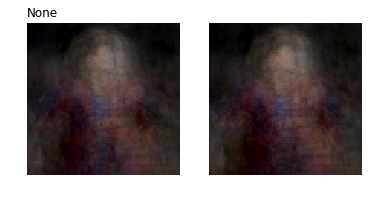

In [13]:
# =============== TODO: Your code here ===============
# Visualize 10 eigenfaces associated with the highest eigenvalues.

for i in range(int(num_eigenfaces/2)):
    print("%d and %d eigenfaces" % ((i*2+1) , (i*2+2)))
    M = (SVDs[i*2], SVDs[i*2+1])
    stack_images(M, k = 1, imgshape=np.array([100, 100, 3]))
# ====================================================

### Implementing eigenfaces with variance maximization

As you have noticed, SVD could be quite slow if the number of faces is large. If the number of faces exceeds 50k, which is not a large dataset according to the modern standards, doing SVD is not possible directly and you have to use iterative methods for computing eigenfaces.

Here, you are going to calculate 10 eigenfaces by maximizing variance as stated in the lecture notes.

In [14]:
from numpy import mean

X_centered = X - mean(X.T, axis=1)

C = np.cov(X_centered.T)

In [15]:
# =============== TODO: Your code here ===============
# Calculate 10 eigenfaces iteratively by variance maximization.


def get_maxeigval(M):
    n_iters = 200000
    return power_iteration(M, n_iters)

def vector_len(v):
    return np.dot(np.transpose(v), v)

def power_iteration(M, n_iters):
    tol = 10**(-9)
    
    vec = np.random.rand(M.shape[0])
    print(M.shape, vec.shape)
    val_old = np.dot(np.transpose(vec), M.dot(vec)) / np.dot(np.transpose(vec), vec)

    for i in range(n_iters):
        vec_temp = M.dot(vec)
        vec_temp_norm = np.linalg.norm(vec_temp)
        vec = vec_temp / vec_temp_norm
        
#         vec = M.dot(vec) / np.linalg.norm(vec)
        val = np.dot(np.transpose(vec), M.dot(vec)) / np.dot(np.transpose(vec), vec)
    
        if (abs(val - val_old) / val) < tol:
            return val, vec
        val_old = val
        
    return val, vec

In [16]:
def get_k_eigenfaces(C, k):
    n_iters = 200000

    print ("Covariance matrix: \n", C.shape)
    
    return power_iteration(C, n_iters)



eigs = get_k_eigenfaces(C, 10)

from numpy.linalg import eig
eigs2 = eig(C)

Covariance matrix: 
 (120, 120)
(120, 120) (120,)


In [17]:
print(eigs[0], eigs2[0][0])
print(eigs[1], np.dot(np.transpose(eigs[1]), eigs[1]))
print(eigs2[1][0], np.dot(np.transpose(eigs2[1][0]), eigs2[1][0]))

row_feature_vectors = eigs[1]
eigenfaces = row_feature_vectors.T.dot(X_centered.T)

row_feature_vectors2 = eigs2[1][0]
# print(row_feature_vectors - row_feature_vectors2)
eigenfaces2 = row_feature_vectors2.T.dot(X_centered.T)
# print(P.T.shape)

73975.46634762592 73975.4663503674
[ 0.0442232   0.0442232   0.00273345 -0.00498444 -0.08743404  0.02675737
 -0.00601184 -0.12034932 -0.02814532  0.0564077   0.07429346  0.00993763
  0.05191027  0.0600411   0.15533354  0.11227696  0.0532328   0.00577409
 -0.00906152  0.08055533  0.09850183 -0.00109586  0.1142869  -0.00182701
  0.07541854  0.21689012  0.19417483  0.11746507  0.0060822  -0.098652
 -0.04678899  0.0955355  -0.15201083  0.18707867 -0.07730082 -0.20368477
  0.02842234 -0.00518609 -0.05696961 -0.09419012  0.06514623  0.20208878
  0.19633606  0.06727486  0.10490694  0.07297783  0.07683408  0.00580596
  0.0317266  -0.17115533  0.0759038   0.04387036 -0.06306223  0.04020922
  0.08062333 -0.02389906  0.04625401  0.14809666 -0.05139613 -0.17806561
  0.09667335  0.0326944   0.16334237  0.03745818  0.06633515 -0.04520569
  0.04122    -0.01512271  0.03716866 -0.10801227  0.06788384  0.08646308
  0.1330764   0.08449576  0.06420571  0.05341475  0.07165081  0.02072956
  0.03341908  0.02

(1, 100, 100, 3)
(1, 100, 100, 3)
(1, 100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


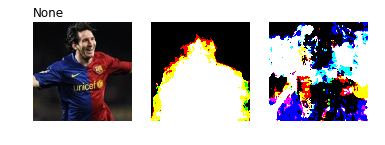

In [18]:
M = (X, eigenfaces, eigenfaces2)
stack_images(M, k = 1, imgshape=np.array([100, 100, 3]))



# print(X_centered.shape, row_feature_vectors.shape)
# X_reduced = np.dot(row_feature_vectors.transpose(), X_centered)
# X_reduced.shape
# M = (SVDs[i*2], SVDs[i*2+1])
#     stack_images(M, k = 1, imgshape=np.array([100, 100, 3]))


# ====================================================

In [22]:
def get_k_eigenfaces2(M, k):
    M_centered = M - mean(M.T, axis=1)
    C = np.cov(X_centered.T)
    
    eigenfaces = []
    row_feature_vectors = np.ndarray
    
    for i in range(k):
        eigs = get_maxeigval(C)
        evec = eigs[1]
        row_feature_vectors.append(evec)
        print(row_feature_vectors[0].shape, evec.shape, M_centered.shape)
        eigenfaces = row_feature_vectors.T.dot(M_centered.T)
        eigenfaces.append(evec)
    
    return eigenfaces
    

In [23]:
eigs = get_k_eigenfaces2(X, 10)

(120, 120) (120,)
(120,) (120,) (30000, 120)


AttributeError: 'list' object has no attribute 'T'

In [ ]:
def custom_PCA(A, N_dimension, debug = False):

    A_centered = np.copy(A)
    for i in range(0, A.shape[0]):
        row = A[i::A.shape[1]]
        A_centered[i::A.shape[1]] = row - row.mean()
    
    if debug == True:
        print("Zero-mean form: \n", A_centered.shape)

    covmat = np.cov(A_centered)
    print ("Covariance matrix: \n", covmat.shape)

    e_values, e_vecs = np.linalg.eig(covmat)
    
    idx = e_values.argsort()[::-1]   
    e_values = e_values[idx]
    e_vecs = e_vecs[:,idx]
    print ("All eigen-values: \n", e_values)
    print ("All eigen-vectors: \n", e_vecs)

    row_feature_vectors = e_vecs[:,:N_dimension]
    print ("Row feature vectors: \n", row_feature_vectors.shapee)

    A_reduced = np.dot(row_feature_vectors.transpose(), A_centered)
    print ("PCA-reduced matrix: \n", A_reduced.shape) 
    print("Sum of distances:", np.sqrt(np.sum(np.power(A_reduced, 2))))
    
    print ("How much of the variance in the data is explained by reduced A: ", e_values[0:N_dimension].sum()/e_values.sum())    
    
    if debug == True:     
        print("----------Debug-------------")
        
#         plt.plot(A_centered[0], A_centered[1], 'o') # plotting t, a separately 
#         plt.plot(A_reduced, 'x')
#         print(e_vecs[:,N_dimension:][0], e_vecs[:,N_dimension:][1])
#         x1, y1 = [0, 0], [row_feature_vectors[0]*5, row_feature_vectors[1]*5]
#         x2, y2 = [0, 0], [e_vecs[:,N_dimension:][0]*20, e_vecs[:,N_dimension:][1]*20]
#         plt.plot(x1,y1, marker = '_')
        
#         means = np.arange(0)
#         for row in A:
#             means = np.append(means, row.mean())
            
#         for n in range(0,5):
#             A_restored = np.dot(A_reduced[n], row_feature_vectors) + m
#             print ('Restored: ', A_restored)
#             print ('Original: ', A_original[:,n])

        from sklearn.decomposition import PCA
        pca = PCA(n_components = N_dimension)
        A_PCAreduced = pca.fit_transform(A.transpose())
        print("pca.explained_variance_ = ", pca.explained_variance_)
#         print ("A_PCAreduced: \n", A_PCAreduced)
#         print ('Diffs: \n', A_reduced - A_PCAreduced.transpose())
        print ('Max diff: \n', np.amax(np.absolute(A_reduced) - np.absolute(A_PCAreduced.transpose())))

custom_PCA(X, 1, True)

Zero-mean form: 
 (30000, 120)
Covariance matrix: 
 (30000, 30000)


Visualize 10 eigenfaces learned by variance maximization. Compare them with SVG generated eigenfaces. 

In [ ]:
# =============== TODO: Your code here ===============
# Visualize 10 eigenfaces learned by variance maximization. Compare them with SVG generated eigenfaces.


# ====================================================